> ## "The goal of parameter identification is rarely the parameter estimates. Rather, the ultimate goal is nearly always a prediction problem" 
>-David Freyberg (1988)

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", 
    message="ModflowDis.sr is deprecated. use Modflow.sr")
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
newparams = {'legend.fontsize':10, 'axes.labelsize':10,
             'xtick.labelsize':10, 'ytick.labelsize':10,
             'font.family':'Univers 57 Condensed', 
             'pdf.fonttype':42}
plt.rcParams.update(newparams)
from IPython.display import Image

# Introduction to the synthetic model for the class

### We have recreated a MODFLOW model that was originally created by David Freyberg at Stanford University in the late 1980s. The  model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg(1988); the forecast stress period uses 25% less recharge and 25% more pumping to represent future drought conditions for a forecast period.

### The inverse problem has 12 head observations, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during the forecast stress periods (observations named and ``rivflux_fore``), and the water level in well cell 6 located at row 28 column 5 at the end of the stress periods (observations named ```fr03c16``` and ```fr04c9```) and `travel_time` from MODPATH.  The forecasts are included in the Jacobian matrix as zero-weight observations. 

### Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

In [ ]:
Image(filename='images/freyberg_paper.png')

/Users/mnfienen/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Univers 57 Condensed'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


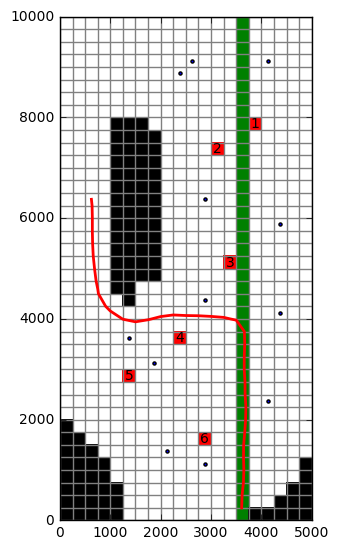

In [2]:
import flopy

# load the model
model_ws = "extra_crispy"
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6.5,6.5))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=ml)
mm.plot_grid()
ax = mm.ax
#ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.0)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("extra_crispy","obs_rowcol.dat"),
                  delim_whitespace=True)
obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

df = pd.read_csv(os.path.join("extra_crispy","freyberg.mppthln"),skiprows=3,
                 header=None,usecols=[5,6],
                 names=['x','y'],
                 delim_whitespace=True)
ax.plot(df.x,df.y,color='r',lw=2.0)
plt.show()    
    
ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.75,1.0),frameon=False)
plt.savefig("domain.pdf")
plt.savefig("domain.png")

# True Properties of the model

/Users/mnfienen/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Univers 57 Condensed'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


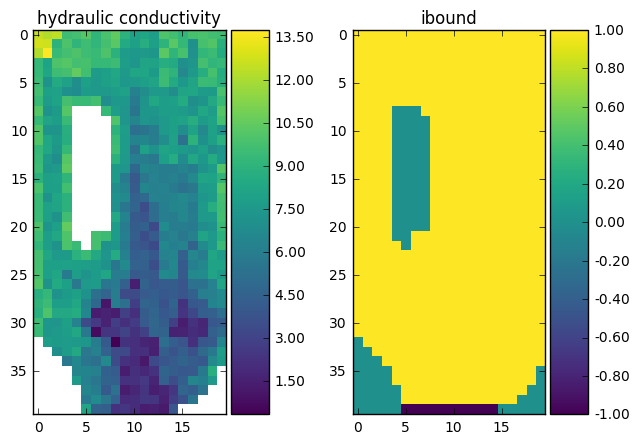

In [3]:
hk = np.loadtxt(os.path.join('extra_crispy','ref','hk.truth.ref'))
ibound = np.loadtxt(os.path.join('extra_crispy','ref','ibound.ref'))
fig = plt.figure(figsize=(6.5,6.5))
ax1 = plt.subplot(121,aspect="equal")
hk[ibound==0] = np.nan
im1 = plt.imshow(hk, interpolation='nearest', cmap='viridis')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="20%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1,  format="%.2f")
ax2 = plt.subplot(122,aspect="equal")
im2 = plt.imshow(ibound, interpolation='nearest', cmap='viridis')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="20%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2,  format="%.2f")
ax1.set_title('hydraulic conductivity')
ax2.set_title('ibound')
plt.tight_layout()

# The hydraulic conductivity is a stochastically perturbed realization based on a zoned field from the paper
<img src="true_K.png" style="float: center; width: 25%;  margin-bottom: 0.5em;">


# How about recharge?

In [4]:
for line in open(os.path.join('extra_crispy','freyberg.truth.rch'),'r'):
    print(line.strip())

# RCH for MODFLOW, generated by Flopy.
3         0
1        -1 # Stress period 1
CONSTANT                   0.00013824                   #rech_1
1        -1 # Stress period 2
CONSTANT                   0.00009000                   #rech_2
1        -1 # Stress period 3
CONSTANT                   0.00009000                   #rech_2


# What did the paper describe and what are we doing?

## David Freyberg designed a simple model to give to a graduate class and asked them to each "calibrate" the model. The data provided to them was pretty extensive: 
### 1. the water level (perfectly represented) in a number of wells
### 2. the bedrock elevation at those same well locations
### 3. all the lateral aquifer geometry
### 4. boundary conditions including lateral flows 
### 5. well pumping rates 

## The forecast of interest was the head if the river channel was lined (e.g. conductance reduced greatly)

## Calibration was judged based on three metrics
## 1. Fit of prediction: $RMSE_P=\sqrt{\frac{1}{6}\sum_{i=1}^{6}\left(\hat{h}_{mod}^{i}-h_{mod}^{i}\right)^{2}}$
## 2. Fit of calibration: $RMSE_K=\sqrt{\frac{1}{705}\sum_{i=1}^{705}\left(\hat{K}_i-K_i\right)^{2}}$
## 3. The number of model runs: $N$

## The students had to make their own metrics of calibration fit using the head observations

# There are interesting insights in the paper, but perhaps the most interesting is this one:

<img src="cal_pred.png" style="float: center; width: 75%;  margin-bottom: 0.5em;">


# So what are we doing with this model?

## The Freyberg paper showed that representing the true properties of a system can lead to good predictions. However, doing a great job of reproducing calibration data _at the expense of reasonable parameters_ hinders rather than helps predictions/forecasts. This is a central theme!

## So we will explore this model, using it to work our way through simple parameterizations and getting more sophisticated as we go. We will explore the ramifications of simplicity and complexity always consider the balance between "calibration" fit and predictive performance.

## For this kind fo class we need a synthetic and kind of simple model so it can run quickly and so we can compare our answers with the truth.

# Calibration Data: 
### We will have the same head values, but they will be corrupted with noise. We will also have river flux as an observation

# Future Condition:
### We want to simulate a future drought condition in which recharge decreases by 25% and pumping increases by 25%

# Forecasts: 
### Our forecasts include head, river flux, and travel time of a particle estimated using MODPATH